### Conversão para PNG

In [1]:
import sys
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))
LOCCA_DIR = ROOT_DIR / 'datasets/locca'

from src.utils.load_image_and_annotation import load_nifti, load_nrrd, visualize_slice  # noqa: E402, F401

In [2]:
def vols_generator(volumes_paths, masks_paths):
    for vol_path, mask_path in zip(volumes_paths, masks_paths):
        yield load_nifti(vol_path)[0], load_nrrd(mask_path)[0], vol_path


volumes = sorted(LOCCA_DIR.glob('images*/*/*.nii.gz'), key=lambda p:p.name)
masks_paths = sorted(LOCCA_DIR.glob('annotations*/*.nrrd'), key=lambda p:p.name)

data_generator = vols_generator(volumes, masks_paths)

#### Teste

Text(0.5, 1.0, 'locca_covid_013.nii.gz')

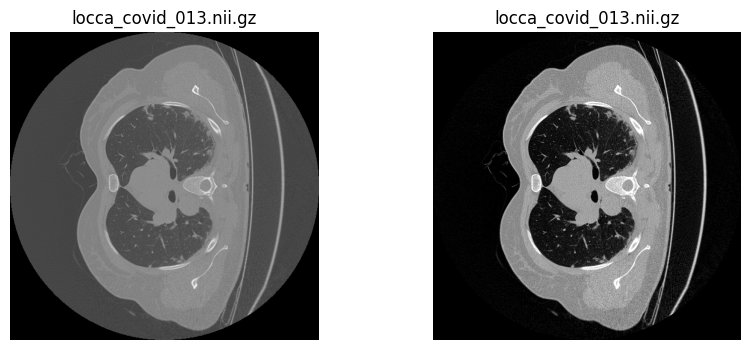

In [140]:
import cv2


idx = random.randint(0, 59)
sample_file = volumes[idx]
sample_mask = masks_paths[idx]
vol, _ = load_nifti(str(sample_file))
masks, _ = load_nrrd(str(sample_mask))

jdx = random.randint(0, vol.shape[-1]-1)
slice = vol[:, :, jdx]
mask = masks[:, :, jdx]

fig = plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(slice, cmap='gray')
plt.axis('off')
plt.title(sample_file.name)


# Janelamento na slice de amostra
new_slice = np.clip(slice, -1000, 650)
new_slice = (new_slice - (-1000)) / (650 - (-1000))
new_slice = (new_slice*255).astype(np.uint8)
# slice = (image - min_val) / (max_val - min_val)

plt.subplot(122)
plt.imshow(new_slice, cmap='gray')
plt.axis('off')
plt.title(sample_file.name)

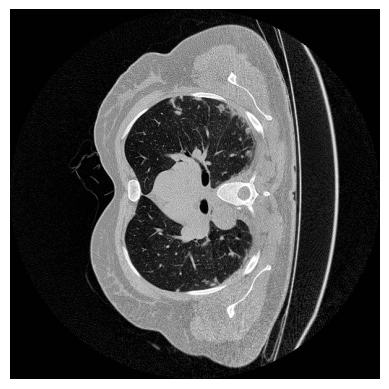

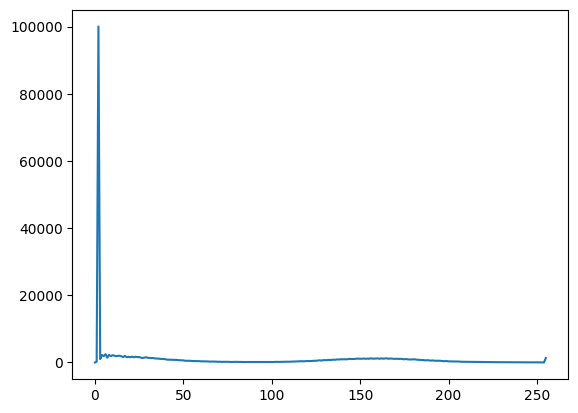

In [142]:
clahe = cv2.createCLAHE(clipLimit=1)
clahe_img = np.clip(clahe.apply(new_slice), 0, 255).astype(np.uint8)
_, threshold_img = cv2.threshold(new_slice, 155, 255, cv2.THRESH_BINARY)

plt.imshow(clahe_img, cmap='gray')
plt.axis('off')
plt.show()

hist = cv2.calcHist([clahe_img],[0],None,[256],[0,256])

plt.plot(hist)
plt.show()

#### Loop de Conversão

In [195]:
def pre_processar(ct_slice: np.array, mask: np.array):
    """Windowing+clahe+median"""


    # Windowing
    new_slice = np.clip(ct_slice, -1000, 650)
    new_slice = (new_slice + 1000) / 1650  # -> [0,1]
    new_slice = (new_slice*255).astype(np.uint8)

    # # Divisão dos pulmões
    mask = mask.astype(np.uint8)
    # right_lung = np.isin(mask, [1,2]).astype(np.uint8)
    # left_lung = np.isin(mask, [3,4,5]).astype(np.uint8)

    # Clahe
    clahe = cv2.createCLAHE(clipLimit=1)
    clahe_img = np.clip(clahe.apply(new_slice), 0, 255).astype(np.uint8)

    # Median Blur
    median = cv2.medianBlur(clahe_img, 3)
    

    # return new_slice, mask, right_lung, left_lung
    return median, mask

In [4]:
import cv2

OUTUP_DIR = LOCCA_DIR / 'pngs_preprocessed'
IMAGES_DIR = OUTUP_DIR / 'images'
MASKS_DIR = OUTUP_DIR / 'masks'

OUTUP_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)
MASKS_DIR.mkdir(exist_ok=True)

In [197]:
cont = 0
for vol, masks, vol_path in tqdm(data_generator, total=60):
    assert vol.shape == masks.shape, "Volume e máscara com shapes diferentes"
    num_slices = vol.shape[-1]

    base_filename = vol_path.name.split('.')[0]


    for i in range(num_slices):
        ct_slice, mask = pre_processar(vol[:, :, i], masks[:, :, i])

        cv2.imwrite(
            str(IMAGES_DIR/f'{base_filename}_{i}.png'), 
            ct_slice 
        )

        cv2.imwrite(
            str(MASKS_DIR/f'{base_filename}_{i}.png'), 
            mask 
        )


  0%|          | 0/60 [00:00<?, ?it/s]

In [200]:
mask = cv2.imread('../datasets/locca/pngs_preprocessed/masks/locca_covid_001_100.png', 0)

In [201]:
np.unique(mask)

array([0, 1, 2, 5], dtype=uint8)

### Sem pré-processamento
Apenas normalização para valores entre 0 e 255

In [5]:
def normalizacao_base(ct_slice: np.array, mask: np.array):
    """Windowing+clahe+median"""


    # Windowing de forma grosseira
    new_slice = np.clip(ct_slice, -1000, 3100)
    new_slice = (new_slice + 1000) / 4100  # -> [0,1]
    new_slice = (new_slice*255).astype(np.uint8)

    mask = mask.astype(np.uint8)

    return new_slice, mask


OUTUP_DIR_2 = LOCCA_DIR / 'pngs'
IMAGES_DIR_2 = OUTUP_DIR_2 / 'images'
MASKS_DIR_2 = OUTUP_DIR_2 / 'masks'

OUTUP_DIR_2.mkdir(exist_ok=True)
IMAGES_DIR_2.mkdir(exist_ok=True)
MASKS_DIR_2.mkdir(exist_ok=True)

In [204]:
for vol, masks, vol_path in tqdm(data_generator, total=60):
    assert vol.shape == masks.shape, "Volume e máscara com shapes diferentes"
    num_slices = vol.shape[-1]

    base_filename = vol_path.name.split('.')[0]

    for i in range(num_slices):
        ct_slice, mask = normalizacao_base(vol[:, :, i], masks[:, :, i])

        cv2.imwrite(
            str(IMAGES_DIR_2/f'{base_filename}_{i}.png'), 
            ct_slice 
        )

        cv2.imwrite(
            str(MASKS_DIR_2/f'{base_filename}_{i}.png'), 
            mask 
        )

  0%|          | 0/60 [00:00<?, ?it/s]

### Divisão treino/teste

In [11]:
import shutil
from typing import List
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split


X = sorted(OUTUP_DIR.glob('images/*.png'))
y = sorted(OUTUP_DIR.glob('masks/locca*.png')) + sorted(OUTUP_DIR.glob('masks/lung*.png'))

In [7]:
for i, j in zip(X,y):
    if i.name != j.name:
        print('Erro na listagem de caminhos!')
        print(i)
        break

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    shuffle=True,
    random_state=96
)

In [13]:
def copy_files(paths: List[Path], storer_dir: Path):
    if not storer_dir.exists():
        storer_dir.mkdir(parents=True, exist_ok=True)

    for path in tqdm(paths):
        shutil.copy(path, storer_dir)



copy_files(X_train, OUTUP_DIR/'train/images')
copy_files(X_test, OUTUP_DIR/'test/images')
copy_files(y_train, OUTUP_DIR/'train/masks')
copy_files(y_test, OUTUP_DIR/'test/masks')

  0%|          | 0/18855 [00:00<?, ?it/s]

  0%|          | 0/3328 [00:00<?, ?it/s]

  0%|          | 0/18855 [00:00<?, ?it/s]

  0%|          | 0/3328 [00:00<?, ?it/s]

#### Movendo os arquivos sem pré-processamento

In [14]:
convert_path = lambda path: str(path).replace("pngs_preprocessed", "pngs")  # noqa: E731

X_train = list(map(convert_path, X_train))
X_test = list(map(convert_path, X_test))
y_train = list(map(convert_path, y_train))
y_test = list(map(convert_path, y_test))

In [15]:
# Atençã-> usar o segundo diretório
copy_files(X_train, OUTUP_DIR_2/'train/images')
copy_files(X_test, OUTUP_DIR_2/'test/images')
copy_files(y_train, OUTUP_DIR_2/'train/masks')
copy_files(y_test, OUTUP_DIR_2/'test/masks')

  0%|          | 0/18855 [00:00<?, ?it/s]

  0%|          | 0/3328 [00:00<?, ?it/s]

  0%|          | 0/18855 [00:00<?, ?it/s]

  0%|          | 0/3328 [00:00<?, ?it/s]